# Responses for RXTE HEXTE

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
# try:
#     import seaborn as sns
# except ImportError:
#     print("No seaborn installed. Oh well.")
    
import numpy as np 
# import pandas as pd
import astropy.io.fits as fits
from astropy.table import Table
import sherpa.astro.ui as ui
import astropy.modeling.models as models
from astropy.modeling.fitting import _fitter_to_model_params
from scipy.special import gammaln as scipy_gammaln
import os.path

# from clarsach.respond import RMF, ARF

failed to import sherpa.image.ds9_backend due to 
'RuntimeErr: DS9Win unusable: Could not find ds9 on your PATH'


### Sherpa Stuff

Daniela is doing some sherpa testing right now ...

In [2]:
datadir = "./"
ui.load_data(id="p1", filename=datadir+"RXTE_HEXTE_ClusterA.fak")

read ARF file ./rxte_hexte_00may26_pwa.arf
read RMF file ./rxte_hexte_97mar20c_pwa.rmf


In [3]:
d = ui.get_data("p1")

In [4]:
# conversion factor from keV to angstrom
c = 12.3984191

# This is the data in angstrom
bin_lo = d.bin_lo
bin_hi = d.bin_hi
print(bin_lo)
counts = d.counts
exposure = d.exposure

channel = d.channel

None


RXTE does not have `BIN_LO` and `BIN_HI` set. Because of course it doesn't.

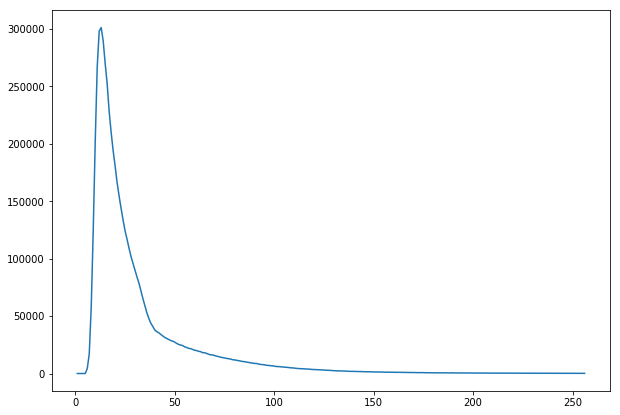

In [5]:
plt.figure(figsize=(10,7))
plt.plot(channel, counts)

RXTE HEXTE has an ARF, just like a regular X-ray telescope (and unlike RXTE/PCA, which doesn't):

In [6]:
arf_list = fits.open(datadir+"rxte_hexte_00may26_pwa.arf")

In [7]:
arf_list[1].data.field("ENERG_LO")[:10]

array([ 10.        ,  10.32999992,  10.67000008,  11.        ,
        11.32999992,  11.67000008,  12.        ,  12.32999992,
        12.67000008,  13.        ], dtype=float32)

In [8]:
arf_list[1].data.columns

ColDefs(
    name = 'ENERG_LO'; format = 'E'; unit = 'keV'
    name = 'ENERG_HI'; format = 'E'; unit = 'keV'
    name = 'SPECRESP'; format = 'E'; unit = 'cm**2'
)

In [9]:
specresp = arf_list[1].data.field("SPECRESP")
energ_lo = arf_list[1].data.field("ENERG_LO")
energ_hi = arf_list[1].data.field("ENERG_HI")

In [10]:
energ_lo.shape

(970,)

Let's also load the rmf:

In [11]:
rmf_list = fits.open(datadir+"rxte_hexte_97mar20c_pwa.rmf")
rmf_list[1].header["TUNIT1"]

'keV'

In [12]:
rmf_list.info()

Filename: ./rxte_hexte_97mar20c_pwa.rmf
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU      10   ()      
  1  MATRIX      BinTableHDU     52   970R x 6C   [1E, 1E, 1I, 3I, 3I, 1PE(251)]   
  2  EBOUNDS     BinTableHDU     44   256R x 3C   [1I, 1E, 1E]   


In [13]:
rmf_list["EBOUNDS"].columns

ColDefs(
    name = 'CHANNEL'; format = '1I'; null = -1
    name = 'E_MIN'; format = '1E'; unit = 'keV'
    name = 'E_MAX'; format = '1E'; unit = 'keV'
)

In [14]:
energ_lo = rmf_list["MATRIX"].data.field("ENERG_LO")
energ_hi = rmf_list["MATRIX"].data.field("ENERG_HI")

bin_lo = rmf_list["EBOUNDS"].data.field("E_MIN")
bin_hi = rmf_list["EBOUNDS"].data.field("E_MAX")
bin_mid = bin_lo + (bin_hi - bin_lo)/2.

Ok, so all of our files have the same units. This is good.

Let's also get the ARF and RMF from sherpa:

In [15]:
arf = d.get_arf()

In [16]:
rmf = d.get_rmf()
rmf

<DataRMF data set instance './rxte_hexte_97mar20c_pwa.rmf'>

Now we can make a model spectrum we can play around with! `clarsach` has an implementation of a Powerlaw model that matches the `ISIS` one that created the data:

In [17]:
from clarsach.models.powerlaw import Powerlaw

In [18]:
pl = Powerlaw(norm=1.0, phoindex=2.0)

In [19]:
m = pl.calculate(ener_lo=energ_lo, ener_hi=energ_hi)

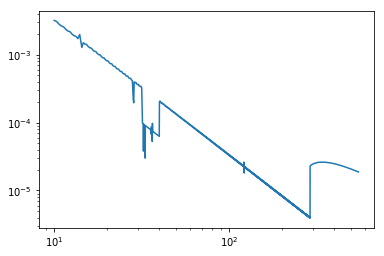

In [20]:
plt.figure()
plt.loglog(energ_lo, m)

In [21]:
m_arf = arf.apply_arf(m)
m_rmf = rmf.apply_rmf(m_arf)

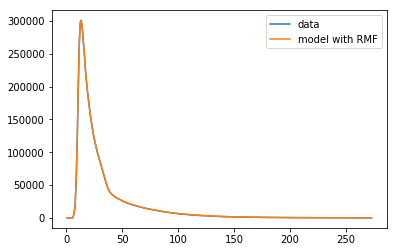

In [22]:
plt.figure()
plt.plot(bin_mid, counts, label="data")
plt.plot(bin_mid, m_rmf*1e5, label="model with RMF")
plt.legend()

Let's save model with ARF and RMF applied:

In [23]:
np.savetxt("../data/rxte_hexte_m_arf.txt", np.array([energ_lo, m_arf]).T)
np.savetxt("../data/rxte_hexte_m_rmf.txt", np.array([bin_mid, m_rmf]).T)

Okay, that looks pretty good!

### Building a Model

Let's build a model for fitting a model to the data. We're going to do nothing fancy here, just a simple Poisson likelihood. It's similar to the one in the `TestAthenaXIFU` notebook, except it uses the `Clarsach` powerlaw function and integrates over bins.

In [24]:
class PoissonLikelihood(object):
    
    def __init__(self, x_low, x_high, y, model, arf=None, rmf=None, exposure=1.0):
        self.x_low = x_low
        self.x_high = x_high
        self.y = y
        self.model = model
        self.arf = arf
        self.rmf = rmf
        self.exposure = exposure
        
    def evaluate(self, pars):
        # store the new parameters in the model

        self.model.norm = pars[0]
        self.model.phoindex = pars[1]
        
        # evaluate the model at the positions x
        mean_model = self.model.calculate(self.x_low, self.x_high)

        # run the ARF and RMF calculations
        if self.arf is not None:
            m_arf = self.arf.apply_arf(mean_model)
            
        else:
            m_arf = mean_model
            
        if self.rmf is not None:
            ymodel = self.rmf.apply_rmf(m_arf)
        else:
            ymodel = mean_model
                
        ymodel += 1e-20
        
        ymodel *= self.exposure
        # compute the log-likelihood
        loglike = np.sum(-ymodel + self.y*np.log(ymodel) \
               - scipy_gammaln(self.y + 1.))

        if np.isfinite(loglike):
            return loglike
        else:
            return -1.e16

    def __call__(self, pars):
        l = -self.evaluate(pars)
        #print(l)
        return l


In [25]:
loglike = PoissonLikelihood(energ_lo, energ_hi, counts, pl, arf=arf, rmf=rmf, exposure=exposure)
loglike([1.0, 2.0])

1381.2197806186014

In [26]:
from scipy.optimize import minimize

In [27]:
opt = minimize(loglike, [1.0, 2.0], method="powell")

In [28]:
opt

   direc: array([[ 0.        ,  1.        ],
       [ 0.00298068,  0.00127701]])
     fun: 1377.9732127624425
 message: 'Optimization terminated successfully.'
    nfev: 107
     nit: 3
  status: 0
 success: True
       x: array([ 1.00281117,  2.00147611])

In [29]:
m_fit = pl.calculate(energ_lo, energ_hi)
m_fit_arf = arf.apply_arf(m_fit)
m_fit_rmf = rmf.apply_rmf(m_fit_arf) * exposure

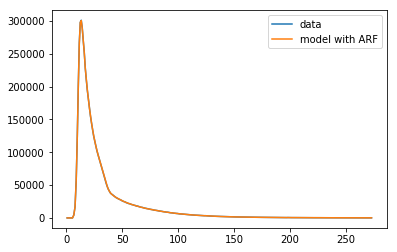

In [30]:
plt.figure()
plt.plot(bin_mid, counts, label="data")
plt.plot(bin_mid, m_fit_rmf, label="model with ARF")
plt.legend()

The sherpa stuff works! Good!

## Making Our Own ARF/RMF Classes

Ideally, we don't want to be dependent on the `sherpa` implementation.
We're now going to write our own implementations, and then test them on the model above.

Let's write a function that applies the ARF, which is just straightforward element-wise multiplication:

In [31]:
def apply_arf(spec, specresp, exposure=1.0):
    """
    Apply the anxilliary response to 
    a spectrum. 
    
    Parameters
    ----------
    spec : numpy.ndarray
        The source spectrum in flux units
        
    specresp: numpy.ndarray
        The response 
        
    exposure : float
        The exposure of the observation
        
    Returns
    -------
    spec_arf : numpy.ndarray
        The spectrum with the response applied.
    
    """
    spec_arf = spec*specresp*exposure
    return spec_arf

In [32]:
m_arf = apply_arf(m, arf.specresp)

In [33]:
m_arf_sherpa = arf.apply_arf(m)

In [34]:
np.allclose(m_arf, m_arf_sherpa)

True

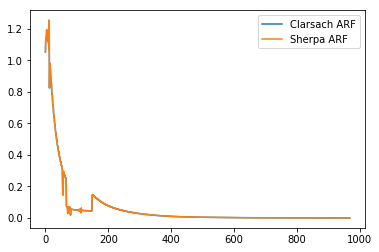

In [35]:
plt.plot(m_arf, label="Clarsach ARF")
plt.plot(m_arf_sherpa, label="Sherpa ARF")
plt.legend()

Let's look at the RMF, which is more complex. This requires a matrix multiplication. However, the response matrices are compressed to remove zeros and save space in memory, so they require a little more complex fiddling. Here's an implementation that is basically almost a line-by-line translation of the C++ code:

In [36]:
def rmf_fold(spec, rmf, nchannels=None):
    
    #current_num_groups = 0
    #current_num_chans = 0
    
    nchannels = spec.shape[0]
    
    resp_idx = 0
    first_chan_idx = 0
    num_chans_idx =0
    counts_idx = 0
    
    counts = np.zeros(nchannels)
    
    for i in range(nchannels):
        source_bin_i = spec[i]
        current_num_groups = rmf.n_grp[i]
        
        while current_num_groups:
            counts_idx = int(rmf.f_chan[first_chan_idx] - rmf.offset)
            current_num_chans = rmf.n_chan[num_chans_idx]
            
            first_chan_idx += 1
            num_chans_idx +=1 
            
            while current_num_chans:
                counts[counts_idx] += rmf.matrix[resp_idx] * source_bin_i
                counts_idx += 1
                resp_idx += 1
                current_num_chans -= 1
            
            current_num_groups -= 1
            
    return counts




Let's see if we can make this more vectorized:

In [37]:
def rmf_fold_vector(spec, rmf, nchannels=None):
    """
    Fold the spectrum through the redistribution matrix.
    
    Parameters
    ----------
    spec : numpy.ndarray
        The (model) spectrum to be folded
        
    rmf : sherpa.RMFData object
        The object with the RMF data
    
    """    
    # get the number of channels in the data
    nchannels = spec.shape[0]
    
    # an empty array for the output counts
    counts = np.zeros(nchannels)
    
    #print('len(nchannels): ' + str(nchannels))
    # index for n_chan and f_chan incrementation
    k = 0
    
    # index for the response matrix incrementation
    resp_idx = 0

    # loop over all channels
    for i in range(nchannels):
        
        # this is the current bin in the flux spectrum to 
        # be folded
        source_bin_i = spec[i]
        
        # get the current number of groups 
        current_num_groups = rmf.n_grp[i]
        
        for j in range(current_num_groups):
            counts_idx = int(rmf.f_chan[k] - rmf.offset)
            current_num_chans = int(rmf.n_chan[k])
            
            k += 1
            
            counts[counts_idx:counts_idx+current_num_chans] += rmf.matrix[resp_idx:resp_idx+current_num_chans] * source_bin_i
            resp_idx += current_num_chans
            
    return counts



Let's time the different implementations and compare them to the `sherpa` version (which is basically a wrapper around the C++):

In [38]:
# not vectorized version
m_rmf = rmf_fold(m_arf, rmf)
%timeit m_rmf = rmf_fold(m_arf, rmf)

10 loops, best of 3: 124 ms per loop


In [39]:
# vectorized version
m_rmf_v = rmf_fold_vector(m_arf, rmf)
%timeit m_rmf_v = rmf_fold_vector(m_arf, rmf)

100 loops, best of 3: 6.64 ms per loop


In [40]:
# C++ (sherpa) version
m_rmf2 = rmf.apply_rmf(m_arf)
%timeit m_rmf2 = rmf.apply_rmf(m_arf)

10000 loops, best of 3: 124 µs per loop


So my vectorized implementation is ~20 times slower than the sherpa version, and the non-vectorized version is *really* slow. But are they all the same?

In [41]:
np.allclose(m_rmf_v[:len(m_rmf2)], m_rmf2)

True

In [42]:
np.allclose(m_rmf[:len(m_rmf2)], m_rmf2)

True

They are! It looks like for this particular RXTE data set, it's working! 

## Making an ARF/RMF Class

the ARF and RMF code would live well in a class, so let's wrap it into a class:

In [43]:
class RMF(object):
    
    def __init__(self, filename):
        
        self._load_rmf(filename)
        pass
    
    def _load_rmf(self, filename):
        """
        Load an RMF from a FITS file.
        
        Parameters
        ----------
        filename : str
            The file name with the RMF file
            
        Attributes
        ----------
        n_grp : numpy.ndarray
            the Array with the number of channels in each 
            channel set
        
        f_chan : numpy.ndarray
            The starting channel for each channel group;
            If an element i in n_grp > 1, then the resulting 
            row entry in f_chan will be a list of length n_grp[i];
            otherwise it will be a single number
            
        n_chan : numpy.ndarray
            The number of channels in each channel group. The same 
            logic as for f_chan applies
            
        matrix : numpy.ndarray
            The redistribution matrix as a flattened 1D vector
            
        energ_lo : numpy.ndarray
            The lower edges of the energy bins
        
        energ_hi : numpy.ndarray
            The upper edges of the energy bins
            
        detchans : int
            The number of channels in the detector
        
        """
        # open the FITS file and extract the MATRIX extension
        # which contains the redistribution matrix and 
        # anxillary information
        hdulist = fits.open(filename)

        # get all the extension names
        extnames = np.array([h.name for h in hdulist])

        # figure out the right extension to use
        if "MATRIX" in extnames:
            h = hdulist["MATRIX"]

        elif "SPECRESP MATRIX" in extnames:
            h = hdulist["SPECRESP MATRIX"]

        data = h.data
        hdr = h.header
        hdulist.close()
        
        # extract + store the attributes described in the docstring 
        n_grp = np.array(data.field("N_GRP"))
        f_chan = np.array(data.field('F_CHAN'))
        n_chan = np.array(data.field("N_CHAN"))
        matrix = np.array(data.field("MATRIX"))

        self.energ_lo = np.array(data.field("ENERG_LO"))
        self.energ_hi = np.array(data.field("ENERG_HI"))
        self.detchans = hdr["DETCHANS"]
        self.offset = self.__get_tlmin(h)

        # flatten the variable-length arrays
        self.n_grp, self.f_chan, self.n_chan, self.matrix = \
                self.__flatten_arrays(n_grp, f_chan, n_chan, matrix)
        
        return
    
    def __get_tlmin(self, h):
        """
        Get the tlmin keyword for `F_CHAN`.
        
        Parameters
        ----------
        h : an astropy.io.fits.hdu.table.BinTableHDU object
            The extension containing the `F_CHAN` column
            
        Returns
        -------
        tlmin : int
            The tlmin keyword
        """
        # get the header
        hdr = h.header
        # get the keys of all 
        keys = np.array(list(hdr.keys()))
        
        # find the place where the tlmin keyword is defined
        t = np.array(["TLMIN" in k for k in keys])
        
        # get the index of the TLMIN keyword
        tlmin_idx = np.hstack(np.where(t))[0]
        
        # get the corresponding value
        tlmin = np.int(list(hdr.items())[tlmin_idx][1])
        
        return tlmin
        
    def __flatten_arrays(self, n_grp, f_chan, n_chan, matrix):
        
        # find all non-zero groups
        nz_idx = (n_grp > 0)
        
        # stack all non-zero rows in the matrix
        matrix_flat = np.hstack(matrix[nz_idx])
        
        # some matrices actually have more elements
        # than groups in `n_grp`, so we'll only pick out
        # those values that have a correspondence in
        # n_grp
        f_chan_new = []
        n_chan_new = []
        for i,t in enumerate(nz_idx):
            if t:
                n = n_grp[i]
                f = f_chan[i]
                nc = n_chan[i]
                f_chan_new.append(f[:n])
                n_chan_new.append(nc[:n])

        n_chan_flat = np.hstack(n_chan_new)
        f_chan_flat = np.hstack(f_chan_new)

        # if n_chan is zero, we'll remove those as well.
        nz_idx2 = (n_chan_flat > 0)
        n_chan_flat = n_chan_flat[nz_idx2]
        f_chan_flat = f_chan_flat[nz_idx2]
        
        return n_grp, f_chan_flat, n_chan_flat, matrix_flat
            
    def apply_rmf(self, spec):
        """
        Fold the spectrum through the redistribution matrix.

        The redistribution matrix is saved as a flattened 1-dimensional 
        vector to save space. In reality, for each entry in the flux 
        vector, there exists one or more sets of channels that this 
        flux is redistributed into. The additional arrays `n_grp`, 
        `f_chan` and `n_chan` store this information:
            * `n_group` stores the number of channel groups for each 
              energy bin
            * `f_chan` stores the *first channel* that each channel 
              for each channel set 
            * `n_chan` stores the number of channels in each channel 
              set 
              
        As a result, for a given energy bin i, we need to look up the 
        number of channel sets in `n_grp` for that energy bin. We 
        then need to loop over the number of channel sets. For each 
        channel set, we look up the first channel into which flux 
        will be distributed as well as the number of channels in the 
        group. We then need to also loop over the these channels and 
        actually use the corresponding elements in the redistribution 
        matrix to redistribute the photon flux into channels. 
        
        All of this is basically a big bookkeeping exercise in making 
        sure to get the indices right.
        
        Parameters
        ----------
        spec : numpy.ndarray
            The (model) spectrum to be folded

        Returns
        -------
        counts : numpy.ndarray
            The (model) spectrum after folding, in 
            counts/s/channel

        """    

        # an empty array for the output counts
        counts = np.zeros_like(spec)

        # index for n_chan and f_chan incrementation
        k = 0

        # index for the response matrix incrementation
        resp_idx = 0

        # loop over all channels
        for i in range(spec.shape[0]):
            # this is the current bin in the flux spectrum to
            # be folded
            source_bin_i = spec[i]

            # get the current number of groups 
            current_num_groups = self.n_grp[i]

            # loop over the current number of groups
            for j in range(current_num_groups):

                current_num_chans = int(self.n_chan[k])

                if current_num_chans == 0:
                    k += 1
                    resp_idx += current_num_chans
                    continue


                else:
                    # get the right index for the start of the counts array 
                    # to put the data into
                    counts_idx = int(self.f_chan[k] - self.offset)
                    # this is the current number of channels to use
                    
                    k += 1
                    # add the flux to the subarray of the counts array that starts with 
                    # counts_idx and runs over current_num_chans channels
                    counts[counts_idx:counts_idx+current_num_chans] +=  self.matrix[resp_idx:resp_idx+current_num_chans] * \
                                                                        np.float(source_bin_i)
                    # iterate the response index for next round
                    resp_idx += current_num_chans


        return counts[:self.detchans]


Let's make an object of that class and then make another model with the RMF applied:

In [44]:
rmf_new = RMF(datadir+"rxte_hexte_97mar20c_pwa.rmf")
m_rmf = rmf_new.apply_rmf(m_arf)

Hooray! What does the total spectrum look like?

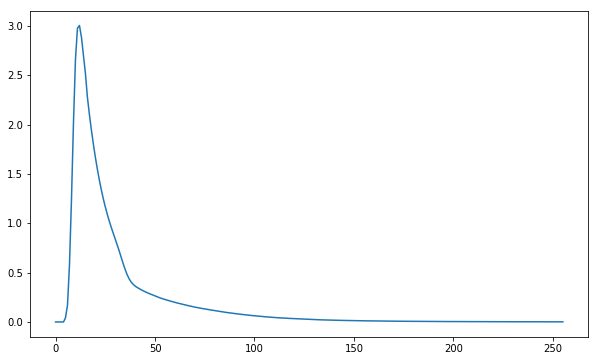

In [45]:
plt.figure(figsize=(10, 6))
plt.plot(m_rmf)
#plt.plot(m_rmf_v)

There is, of course, also an implementation in `clarsach`:

In [46]:
from clarsach import respond

In [47]:
rmf_c = respond.RMF(datadir+"rxte_hexte_97mar20c_pwa.rmf")

In [48]:
m_rmf_c = rmf_new.apply_rmf(m_arf)

In [49]:
np.allclose(m_rmf_c, m_rmf2)

True

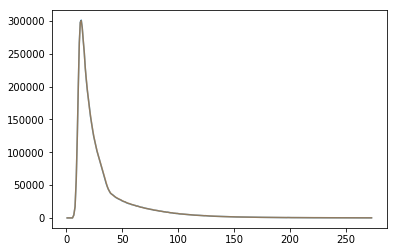

In [50]:
plt.figure()
plt.plot(bin_mid, counts, label="data")
plt.plot(bin_mid, m_rmf_c*exposure, label="model", alpha=0.5)

And it works! Woo!